In [1]:
import pandas as pd
import numpy as np
import math
import pickle
from sqlalchemy import create_engine
from matplotlib import pyplot as plt

In [2]:
# データベースの情報
server = 'gciteam16.database.windows.net'
database = 'mynavi-database'
username = 'gciteam16'
password = 'Password0'
port =1433

In [36]:
# 接続エンジンの作成
engine_config = "?driver=ODBC+Driver+13+for+SQL+Server?charset=shift-jis"
db_settings = {
    "host": server,
    "database": database,
    "user": username,
    "password": password,
    "port":port,
    "config_query":engine_config
}
engine = create_engine('mssql+pyodbc://{user}:{password}@{host}:{port}/{database}{config_query}'.format(**db_settings))

In [37]:
query = "SELECT * FROM analytical_data_table"
analytical_data = pd.read_sql(query, con=engine)

In [5]:
#with open('../../gci_project_storage/analytical_data.pickle', mode='rb') as f:
#     analytical_data = pickle.load(f)

<h3>データ整形

In [38]:
analytical_data = analytical_data.reindex(np.random.permutation(analytical_data.index)).reset_index().drop("index", axis=1)

In [40]:
X = analytical_data.iloc[:,3:]
y = analytical_data.iloc[:,:3].rent

<h3>交差検証

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.cross_validation import cross_val_score

models = [
    LinearRegression()
    ,Lasso(alpha=0.05)
    ,Lasso(alpha=0.1)
    ,Lasso(alpha=0.2)
    ,Ridge(alpha=0.05)
    ,Ridge(alpha=0.1)
    ,Ridge(alpha=0.2)
    ,RandomForestRegressor(n_estimators=100)
    ,LinearSVR()
    ]

In [42]:
for model in models:
    scores = cross_val_score(model, X, y,cv=4)
    print(model.__class__.__name__, "   \tscores:\t", scores )

LinearRegression    	scores:	 [ 0.8259293   0.81132257  0.79806772  0.81508043]
Lasso    	scores:	 [ 0.76089462  0.73632422  0.72861668  0.74755066]
Lasso    	scores:	 [ 0.74995429  0.72756404  0.71710381  0.73673429]
Lasso    	scores:	 [ 0.73849682  0.71875901  0.70555761  0.72539117]
Ridge    	scores:	 [ 0.82632788  0.81230204  0.79839565  0.81533149]
Ridge    	scores:	 [ 0.82643048  0.81277925  0.79826195  0.81548445]
Ridge    	scores:	 [ 0.82652902  0.81343975  0.79787005  0.81561597]
RandomForestRegressor    	scores:	 [ 0.91949457  0.94745353  0.8926265   0.89545373]
LinearSVR    	scores:	 [ 0.68721351  0.71183894  0.65497792  0.70256031]


<h3>重要度を確認

In [11]:
model_r = RandomForestRegressor(n_estimators=200)
model_r.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [43]:
importance = pd.Series(model_r.feature_importances_,index=X.columns)
print("駅の重要度合計：",importance[145:].sum())
print("間取りの重要度合計：",importance[50:55].sum())
for index,value in importance.sort_values(ascending=False).iteritems():
    print(index,":\t",value)

駅の重要度合計： 0.0669732362887
間取りの重要度合計： 0.311722132423
area :	 0.4261165283486308
has_L :	 0.30914701313633175
address_lat :	 0.04694327670973324
year_built :	 0.03750599009119652
address_lng :	 0.03320010484610684
渋谷駅 :	 0.01788831160728957
auto_lock :	 0.01390787638167863
恵比寿駅 :	 0.012327879331843221
buildings_height_Null_to_Zero :	 0.011029344149469586
refrigerator_Null_to_Zero :	 0.008806424857957821
表参道駅 :	 0.006439957537741597
locality_Null_to_Zero :	 0.004366138456783898
total_units_Null_to_Zero :	 0.004087091805645205
代々木公園駅 :	 0.0038177857091991237
明治神宮前駅 :	 0.0031288123502052696
bath_drier_Null_to_Zero :	 0.0027552054771722173
原宿駅 :	 0.002275854348493336
代々木八幡駅 :	 0.0015744508580821709
the_number_of_rooms :	 0.0014548916277310432
the_number_of_rooms_Null_to_Zero :	 0.001447474816480895
top_floor :	 0.001442319788134346
代官山駅 :	 0.0014172254686672337
stove_num_Null_to_Zero :	 0.0012953630288683076
代々木駅 :	 0.001188564317237567
structure :	 0.001184070268810826
structure_4 :	 0.00114

<h3>残差の可視化

In [46]:
model_r_20000 = RandomForestRegressor(n_estimators=100)
model_r_20000.fit(X.iloc[:20000,:],y[:20000])
y_pred_20000 = model_r_20000.predict(X.iloc[20000:,:])

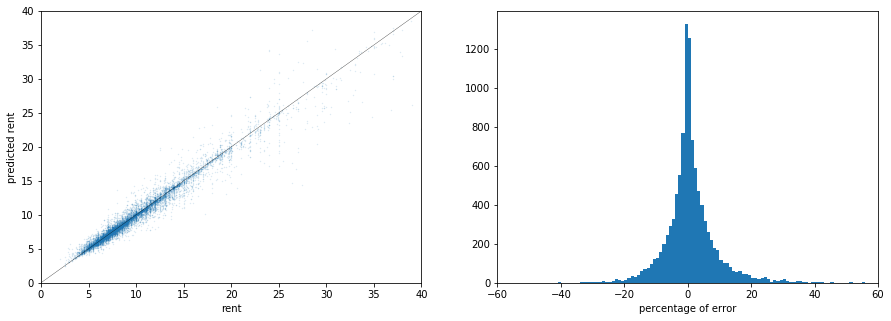

In [47]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(x=y[20000:],y=y_pred_20000,s=0.1,alpha=0.2)
plt.xlim(0,40)
plt.ylim(0,40)
plt.xlabel("rent")
plt.ylabel("predicted rent")
plt.plot([0,40],[0,40],c="black",linewidth=0.3)
plt.subplot(1,2,2)
plt.hist((y_pred_20000/y[20000:]-1)*100, bins=range(-60,60))
plt.xlim(-60,60)
plt.xlabel("percentage of error")
plt.show()

<h3>お買い得物件の検索

In [48]:
print("割高な物件の平均価格",y[20000:][(y[20000:]-y_pred_20000)>0].mean())
print("割安な物件の平均価格",y[20000:][(y[20000:]-y_pred_20000)<0].mean())

割高な物件の平均価格 10.984006599378922
割安な物件の平均価格 9.37703720345083


In [49]:
(y[20000:]-y_pred_20000).var()**(1/2)

2.1262158105960287

In [50]:
percentage_price_pred = 100*(y_pred_20000/y[20000:]).sort_values(ascending=False)

In [58]:
index_bad_price = percentage_price_pred.sort_values(ascending=True).index
index_good_price = percentage_price_pred.sort_values(ascending=False).index

In [59]:
print("割高な物件")
for i in index_bad_price[0:100]:
    if is_404(list(analytical_data.url[X.index==i])[0])==False:
        print(list(analytical_data.url[X.index==i])[0]
              ,list(analytical_data.rent[X.index==i])[0]
              ,"万円　相場の"
              ,(y[i]/model_r_20000.predict(X[X.index==i])[0])*100
              ,"％の価格！")

print("お買い得物件")
for i in index_good_price[0:100]:
    if is_404(list(analytical_data.url[X.index==i])[0])==False:
        print(list(analytical_data.url[X.index==i])[0]
              ,list(analytical_data.rent[X.index==i])[0]
              ,"万円　相場の"
              ,(y[i]/model_r_20000.predict(X[X.index==i])[0])*100
              ,"％の価格！")

割高な物件
https://chintai.mynavi.jp/tokyo/116/room2500008925.html 17.3 万円　相場の 170.65351418 ％の価格！
https://chintai.mynavi.jp/tokyo/113/room22300007704.html 55.0 万円　相場の 167.427701674 ％の価格！
https://chintai.mynavi.jp/tokyo/113/room109700008499.html 48.0 万円　相場の 166.216496987 ％の価格！
https://chintai.mynavi.jp/tokyo/113/room3231600005354.html 90.0 万円　相場の 155.965146988 ％の価格！
https://chintai.mynavi.jp/tokyo/106/room687600004143.html 12.0 万円　相場の 151.821862348 ％の価格！
https://chintai.mynavi.jp/tokyo/116/room693000004190.html 26.4 万円　相場の 150.145026446 ％の価格！
https://chintai.mynavi.jp/tokyo/113/room531400007095.html 12.3 万円　相場の 150.0 ％の価格！
https://chintai.mynavi.jp/tokyo/112/room6100008863.html 39.0 万円　相場の 148.697183904 ％の価格！
https://chintai.mynavi.jp/tokyo/113/room593300007095.html 11.5 万円　相場の 147.587268994 ％の価格！
https://chintai.mynavi.jp/tokyo/112/room1186800004203.html 20.6 万円　相場の 147.543331901 ％の価格！
https://chintai.mynavi.jp/tokyo/113/room565300000205.html 45.0 万円　相場の 145.583953413 ％の価格！
https://chintai.

In [52]:
analytical_data.year_built.mean()

1999.5950598802394

In [22]:
import urllib
import re
import time

def is_404(url):
    time.sleep(3)
    try:
        uh = urllib.request.urlopen(url)
        return False
    except urllib.error.HTTPError as err:
        if err.code == 404:
            return True
        else:
            raise

In [23]:
good_404 = "割安物件は、100件中{}件が、掲載終了".format(analytical_data.url[index_good_price[:100]].apply(is_404).sum())
bad_404 = "割高物件は、100件中{}件が、掲載終了".format(analytical_data.url[index_bad_price[:100]].apply(is_404).sum())

In [24]:
print(good_404)
print(bad_404)

割安物件は、100件中60件が、掲載終了
割高物件は、100件中64件が、掲載終了


<h3>実装用の予測モデルの作成

In [53]:
X_avoid_0_to_7682 = X.iloc[pd.Series(range(7682,30728)),:]
X_avoid_7682_to_15364 = X.iloc[pd.Series(list(range(0,7682))+list(range(15364,30728))),:]
X_avoid_15364_to_23046 = X.iloc[pd.Series(list(range(0,15364))+list(range(23046,30728))),:]
X_avoid_23046_to_30728 = X.iloc[pd.Series(range(0,23046)),:]

y_avoid_0_to_7682 = y[pd.Series(range(7682,30728))]
y_avoid_7682_to_15364 = y[pd.Series(list(range(0,7682))+list(range(15364,30728)))]
y_avoid_15364_to_23046 = y[pd.Series(list(range(0,15364))+list(range(23046,30728)))]
y_avoid_23046_to_30728 = y[pd.Series(range(0,23046))]

RF_avoid_0_to_7682 = RandomForestRegressor(n_estimators=100).fit(X_avoid_0_to_7682,y_avoid_0_to_7682)
RF_avoid_7682_to_15364 = RandomForestRegressor(n_estimators=100).fit(X_avoid_7682_to_15364,y_avoid_7682_to_15364)
RF_avoid_15364_to_23046 = RandomForestRegressor(n_estimators=100).fit(X_avoid_15364_to_23046,y_avoid_15364_to_23046)
RF_avoid_23046_to_30728 = RandomForestRegressor(n_estimators=100).fit(X_avoid_23046_to_30728,y_avoid_23046_to_30728)
RF_whole_data = RandomForestRegressor(n_estimators=100).fit(X,y)
RF_models = {
    "RF_avoid_0_to_7682":RF_avoid_0_to_7682
    ,"RF_avoid_7682_to_15364":RF_avoid_7682_to_15364
    ,"RF_avoid_15364_to_23046":RF_avoid_15364_to_23046
    ,"RF_avoid_23046_to_30728":RF_avoid_23046_to_30728
    ,"RF_whole_data":RF_whole_data
}

In [54]:
with open('../../gci_project_storage/RF_models.pickle', mode='wb') as f:
     pickle.dump(RF_models, f)

In [55]:
train_data_urls = analytical_data.url

In [56]:
with open('../../gci_project_storage/train_data_urls.pickle', mode='wb') as f:
     pickle.dump(train_data_urls, f)

In [57]:
print("fin.")

fin.
